In [ ]:
# Copyright 2024 Forusone
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - MaaS Llama 3.2 models with Open AI library
This notebook demonstrates how to get started with using the **OpenAI** library and demonstrates how to leverage multimodal capabilities of Llama 3.2 models as Model-as-service (MaaS).

In [1]:
# @title Install Vertex AI SDK for Python and other required packages
! pip3 install --upgrade --quiet google-cloud-aiplatform openai gradio

In [4]:
# @title Define constants

PROJECT_ID="ai-hangsik" # @param {type:"string"}
LOCATION="us-central1" # @param {type:"string"}


In [5]:
# @title GCP Authentication

# Use OAuth to access the GCP environment.
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user(project_id=PROJECT_ID)

In [6]:
# @title Initialize Vertex AI SDK for Python
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

Import libraries to use in this tutorial.

In [7]:
# @title Import libraries
import json
import re
import uuid
from io import BytesIO

import gradio as gr
import matplotlib.pyplot as plt
# Chat completions API
import openai
from google.auth import default, transport
from google.cloud import storage
from PIL import Image

### Configure OpenAI SDK for the Llama 3.2 Chat Completions API

In [8]:
# @title Authentication
credentials, _ = default()
auth_request = transport.requests.Request()
credentials.refresh(auth_request)

In [9]:
MODEL_LOCATION = "us-central1"
MAAS_ENDPOINT = f"{MODEL_LOCATION}-aiplatform.googleapis.com"

client = openai.OpenAI(
    base_url=f"https://{MAAS_ENDPOINT}/v1beta1/projects/{PROJECT_ID}/locations/{LOCATION}/endpoints/openapi",
    api_key=credentials.token,
)

### Llama 3.2 MaaS
[Check out Llama 3.2 model card](https://console.cloud.google.com/vertex-ai/publishers/meta/model-garden/llama3-2?_ga=2.31261500.2048242469.1721714335-1107467625.1721655511)

In [10]:
MODEL_ID = "meta/llama-3.2-90b-vision-instruct-maas"  # @param {type:"string"} ["meta/llama-3.2-90b-vision-instruct-maas"]

In [26]:
# @title request
response = client.chat.completions.create(
    model=MODEL_ID,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "image_url": {
                        "url": "gs://github-repo/img/gemini/intro/landmark1.jpg"
                    },
                    "type": "image_url",
                },
                {"text": "What’s in this image?", "type": "text"},
            ],
        },
        {"role": "assistant", "content": "In this image, you have:"},
    ],
    max_tokens=4096,

)



You get the response as shown below.

In [27]:
print(response.choices[0].message.content)

* The Elizabeth Tower, commonly known as Big Ben, is a prominent landmark in London, England. It is located at the north end of the Palace of Westminster and is one of the most iconic symbols of the city.
* The Palace of Westminster, also known as the Houses of Parliament, is the meeting place of the UK Parliament. It is a large complex of buildings that includes the House of Commons, the House of Lords, and other offices and facilities.
* Westminster Bridge is a road and foot traffic bridge over the River Thames in London, linking the city of Westminster and the borough of Lambeth. The bridge is painted green, the same color as the leather seats in the House of Commons which is at its north end.
* The River Thames is a major river in southern England that flows through the city of London. It is approximately 215 miles (346 km) long and is the longest river in England.
* The sky is cloudy and overcast, with a few patches of blue visible through the clouds. The overall atmosphere of the

In [28]:
# @title Helpers functions
def visualize_image_from_bucket(bucket_name: str, blob_name: str) -> None:
    """Visualizes an image stored in a Google Cloud Storage bucket."""
    try:
        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)
        image_data = blob.download_as_bytes()
        image = Image.open(BytesIO(image_data))

        plt.figure(figsize=(10, 10))  # Set the figure size (adjust as needed)
        plt.imshow(image)
        plt.axis("off")  # Turn off axis labels
        plt.show()

    except Exception as e:
        print(f"Error visualizing image: {e}")

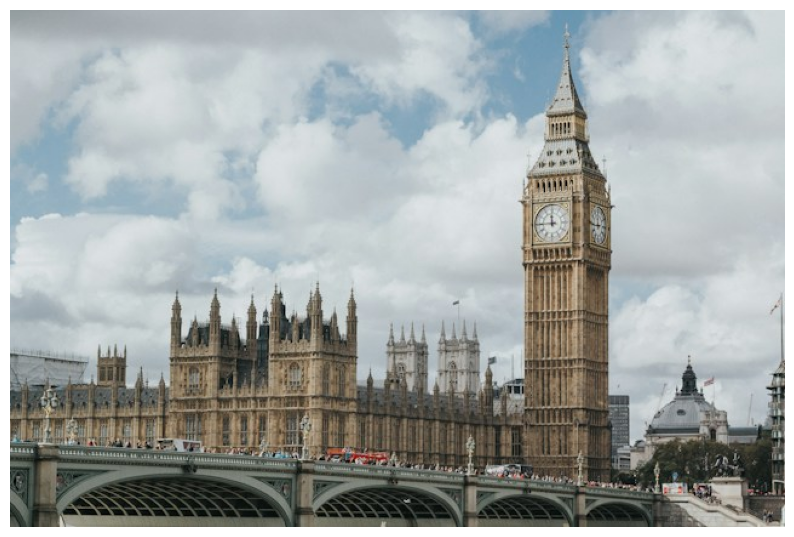

In [29]:
# @title visualize the image.
visualize_image_from_bucket("github-repo", "img/gemini/intro/landmark1.jpg")

In [33]:
# @title Generation parameters

response = client.chat.completions.create(
    model=MODEL_ID,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "image_url": {
                        "url": "gs://github-repo/img/gemini/intro/landmark2.jpg"
                    },
                    "type": "image_url",
                },
                {"text": "What’s in this image?", "type": "text"},
            ],
        },
        {"role": "assistant", "content": "In this image, you have:"},
    ],
    temperature=1.0 ,
    max_tokens=4096,
    top_p=1,
    stream=True,
)


In [34]:
stream = True
if stream:
    for chunk in response:
        print(chunk.choices[0].delta.content, end="")
else:
    print(response.choices[0].message.content)

-The Sky: The sky is a blue gradient, starting with a lighter blue at the bottom and a darker blue at the top. It has a few small, fluffy clouds scattered throughout.
-The Eiffel Tower: The Eiffel Tower is a poorly defined grey tower that is tall and narrow. It has one main beam that starts narrow near the top and ends near three separate beams.
-Vegetation: There are many green trees that appear to be towering next to the Eiffel Tower. They also appear to be trimmed in at the top and have purple flowers. There are also small bushes on the other side of the Eiffel Tower.
-Landmark: Directly behind some of the trees, there is what looks to be a white monument with a chamber in the middle that appears to smile at the visitor. The top of the monument is mostly obscured by trees, but it is shaped like a triangle.
-Road: There is a way behind the landmark that is divided in two sections and made of cement. Vehicles of all sizes are on it.
-People: There are small outlines of people running,